# **Introduction**

This notebook processes single-cell RNA sequencing data from the GSE300475 dataset to prepare it for downstream multimodal analysis. It covers performing normalization, log-transformation, and selection of highly variable genes to reduce noise and focus on informative features. Key preprocessing steps are visualized, including gene variability and dimensionality reduction using PCA, both before and after filtering. Finally, the processed gene expression data is exported to support integration with other data modalities and enable machine learning modeling of treatment response in breast cancer.

In [14]:
# !pip install scanpy

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Load annotated data
adata = sc.read_h5ad("../Data/gene_expression_symbol.h5ad")
print(f"Before processing: {adata.n_obs} cells, {adata.n_vars} genes")
gene_meta = pd.read_csv('model_genes.csv')

Before processing: 58177 cells, 36601 genes


In [17]:
adata

AnnData object with n_obs × n_vars = 58177 × 36601
    obs: 'sample_id', 'patient_id', 'response'
    var: 'symbol'

In [21]:
adata_before = adata.copy()

## Apply QC on Transcriptomics Data

In [22]:
adata.var['symbol'] = adata.var['symbol'].astype(str)
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var['mt'] = adata.var['symbol'].str.upper().str.startswith('MT-')
print("Number of mitochondrial genes found:", adata.var['mt'].sum())

# ribosomal genes
adata.var["ribo"] = adata.var['symbol'].str.upper().str.startswith(("RPS", "RPL"))
# hemoglobin genes. Pls note this dataset isperipheral blood
adata.var["hb"] = adata.var['symbol'].str.upper().str.startswith("^HB[^(P)]")

Number of mitochondrial genes found: 13


In [23]:
adata.var[adata.var['mt'] ==True]

,symbol,mt,ribo,hb
ENSG00000198888,MT-ND1,True,False,False
ENSG00000198763,MT-ND2,True,False,False
ENSG00000198804,MT-CO1,True,False,False
ENSG00000198712,MT-CO2,True,False,False
ENSG00000228253,MT-ATP8,True,False,False
ENSG00000198899,MT-ATP6,True,False,False
ENSG00000198938,MT-CO3,True,False,False
ENSG00000198840,MT-ND3,True,False,False
ENSG00000212907,MT-ND4L,True,False,False
ENSG00000198886,MT-ND4,True,False,False


In [24]:
# mitochondrial genes are flagged
adata.var['mt'] = adata.var['symbol'].astype(str).str.upper().str.startswith('MT-')

# Compute QC metrics, including mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True,  log1p=True, percent_top=[20])

print(adata.obs['pct_counts_mt'].describe())


count    58177.000000
mean         6.728272
std          8.037989
min          0.000000
25%          3.237312
50%          4.792538
75%          6.968641
max         98.429749
Name: pct_counts_mt, dtype: float64


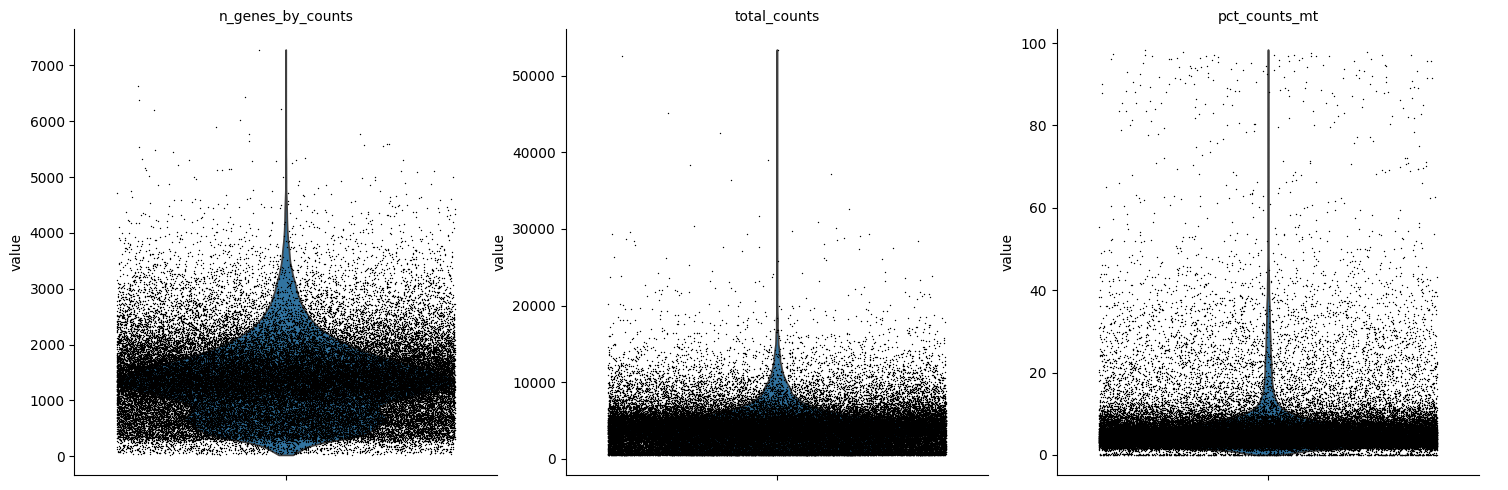

In [25]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

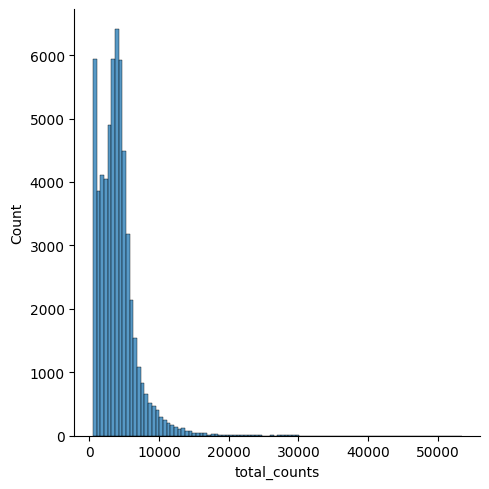

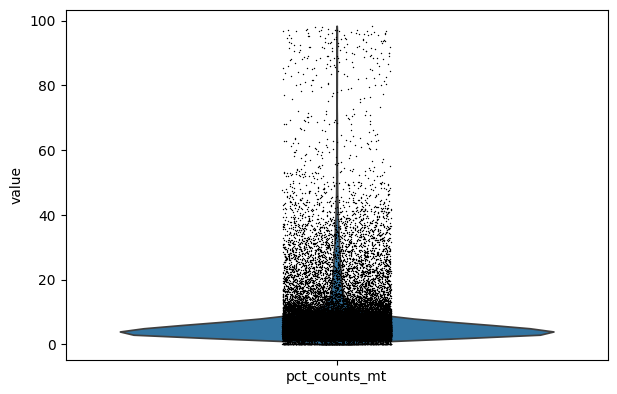

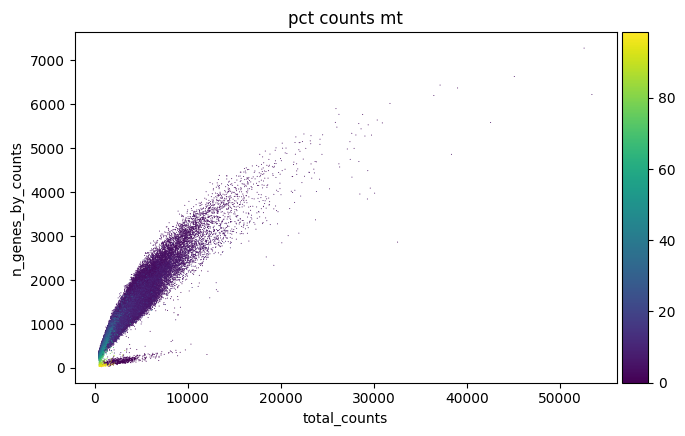

In [26]:
# sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Filter low quality genes

In [27]:
# Quality control
# Follow: https://scanpy-tutorials.readthedocs.io/en/latest/basic-scrna-tutorial.html

from scipy.stats import median_abs_deviation

sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=3)

# Remove outliers if any
# https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print(adata.obs.outlier.value_counts())
adata.obs["mt_outlier"] =  adata.obs["pct_counts_mt"] > 20

print(adata.obs.mt_outlier.value_counts())

outlier
False    54015
True      3243
Name: count, dtype: int64
mt_outlier
False    54772
True      2486
Name: count, dtype: int64


In [28]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 57258
Number of cells after filtering of low quality cells: 53338


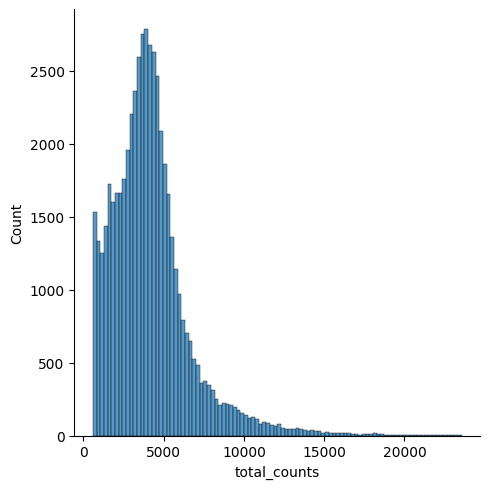

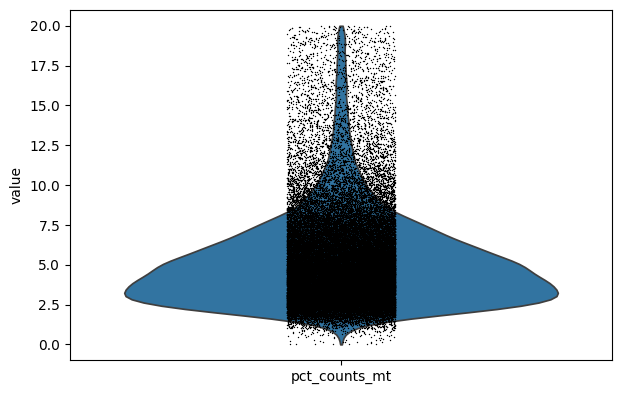

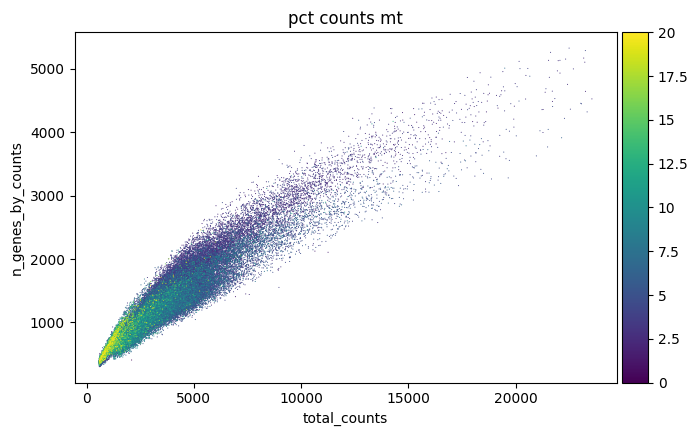

In [29]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Checking for doublets and handling

In [30]:
import scanpy.external as sce

In [31]:
# Make a copy to store results
adata_scrub = adata.copy()

# Store doublet predictions
adata_scrub.obs['doublet_score'] = 0.0
adata_scrub.obs['predicted_doublet'] = False

# Process per batch to save memory
batches = adata_scrub.obs['sample_id'].unique()
for batch in batches:
    print(f"Processing batch: {batch}")
    adata_batch = adata_scrub[adata_scrub.obs['sample_id'] == batch].copy()

    # Run Scrublet
    sce.pp.scrublet(
        adata_batch,
        batch_key=None,  # batch already subsetted
        expected_doublet_rate=0.06,
        sim_doublet_ratio=1.0,
        n_prin_comps=20
    )

    # Assign back to main AnnData
    adata_scrub.obs.loc[adata_batch.obs_names, 'doublet_score'] = adata_batch.obs['doublet_score']
    adata_scrub.obs.loc[adata_batch.obs_names, 'predicted_doublet'] = adata_batch.obs['predicted_doublet']

Processing batch: GSM9061665_S1


C:\Users\minht\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


Processing batch: GSM9061666_S2


C:\Users\minht\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


Processing batch: GSM9061667_S3


C:\Users\minht\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


Processing batch: GSM9061668_S4


C:\Users\minht\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


Processing batch: GSM9061669_S5


C:\Users\minht\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


Processing batch: GSM9061673_S9


C:\Users\minht\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


Processing batch: GSM9061674_S10


C:\Users\minht\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


In [32]:
# Optional: remove predicted doublets
adata_filtered = adata_scrub[~adata_scrub.obs['predicted_doublet']].copy()

# Summary
n_doublets = adata_scrub.obs['predicted_doublet'].sum()
print(f"Total predicted doublets: {n_doublets}/{adata_scrub.n_obs} ({n_doublets/adata_scrub.n_obs:.2%})")
print(f"Cells after removing doublets: {adata_filtered.n_obs}")

Total predicted doublets: 507/53338 (0.95%)
Cells after removing doublets: 52831


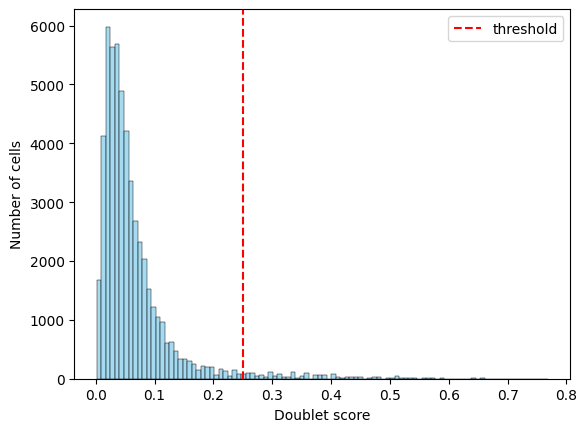

In [33]:
sns.histplot(adata_scrub.obs['doublet_score'], bins=100, color='skyblue')
plt.axvline(0.25, color='red', linestyle='--', label='threshold')
plt.xlabel('Doublet score')
plt.ylabel('Number of cells')
plt.legend()
plt.show()

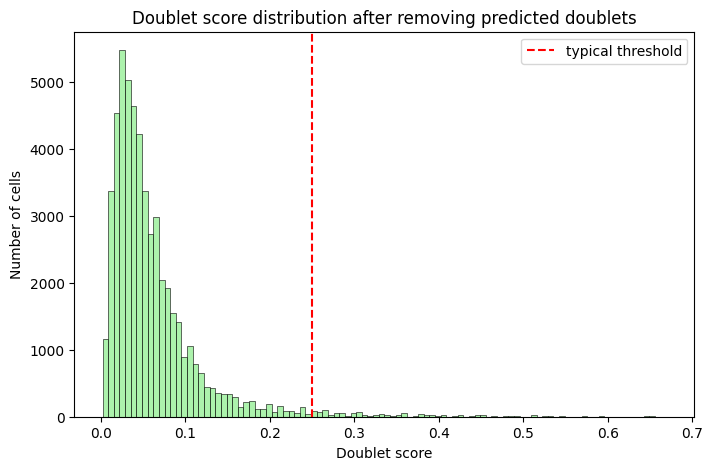

In [34]:
# Subset to remaining cells (after doublet removal)
adata_after = adata_scrub[~adata_scrub.obs['predicted_doublet']].copy()

# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(adata_after.obs['doublet_score'], bins=100, color='lightgreen')
plt.axvline(0.25, color='red', linestyle='--', label='typical threshold')
plt.xlabel('Doublet score')
plt.ylabel('Number of cells')
plt.title('Doublet score distribution after removing predicted doublets')
plt.legend()
plt.show()

In [35]:
# Before removing doublets
total_cells_before = adata_scrub.n_obs
predicted_doublets_before = adata_scrub.obs['predicted_doublet'].sum()
singlets_before = total_cells_before - predicted_doublets_before
mean_score_before = adata_scrub.obs['doublet_score'].mean()
median_score_before = adata_scrub.obs['doublet_score'].median()

print("--- Before removing doublets ---")
print(f"Total cells: {total_cells_before}")
print(f"Predicted doublets: {predicted_doublets_before}")
print(f"Predicted singlets: {singlets_before}")
print(f"Mean doublet score: {mean_score_before:.4f}")
print(f"Median doublet score: {median_score_before:.4f}")
print()

# After removing doublets
adata_after = adata_scrub[~adata_scrub.obs['predicted_doublet']].copy()
total_cells_after = adata_after.n_obs
mean_score_after = adata_after.obs['doublet_score'].mean()
median_score_after = adata_after.obs['doublet_score'].median()

print("--- After removing doublets ---")
print(f"Total cells: {total_cells_after}")
print(f"Mean doublet score: {mean_score_after:.4f}")
print(f"Median doublet score: {median_score_after:.4f}")


--- Before removing doublets ---
Total cells: 53338
Predicted doublets: 507
Predicted singlets: 52831
Mean doublet score: 0.0655
Median doublet score: 0.0457

--- After removing doublets ---
Total cells: 52831
Mean doublet score: 0.0623
Median doublet score: 0.0451


In [90]:
adata_after.layers["counts"] = adata_after.X.copy()
print(f"Raw counts saved. Layer keys: {adata_after.layers.keys()}")

Raw counts saved. Layer keys: KeysView(Layers with keys: counts)


In [91]:
adata_after

AnnData object with n_obs × n_vars = 52831 × 22735
    obs: 'sample_id', 'patient_id', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet'
    var: 'symbol', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts'

In [ ]:
# adata_after.write_h5ad("gene_expression_processed1.h5ad")

## Generate Final Transcriptomics Data for 5000 HVG

In [ ]:
#  You can start from here. No need to rerun the above analysis
adata = sc.read_h5ad("gene_expression_processed1.h5ad")

In [101]:
adata

AnnData object with n_obs × n_vars = 52831 × 22735
    obs: 'sample_id', 'patient_id', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet'
    var: 'symbol', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'response'
    layers: 'counts'

In [ ]:
# --- Normalization and log-transform ---
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# --- Compute HVGs but do NOT subset (retain all genes) ---
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=False)

# --- Print HVG summary stats (optional but good for verification) ---
print("Highly Variable Genes selection counts:")
print(adata.var['highly_variable'].value_counts())
print("\nSummary statistics of gene means and dispersions:")
print(adata.var[['means', 'dispersions', 'dispersions_norm']].describe())

# --- Plot HVG selection curve ---
# sc.pl.highly_variable_genes(adata, save=False)

Highly Variable Genes selection counts:
highly_variable
False    17735
True      5000
Name: count, dtype: int64

Summary statistics of gene means and dispersions:
              means   dispersions  dispersions_norm
count  2.273500e+04  22727.000000      22727.000000
mean   1.613837e-01      1.376082          0.000044
std    3.699218e-01      0.445417          0.999602
min    1.000000e-12     -0.615357         -4.533753
25%    1.435658e-03      1.220120         -0.404624
50%    2.512826e-02      1.337774         -0.074510
75%    1.764122e-01      1.473191          0.240613
max    5.249661e+00      6.398817         12.816979


In [96]:
hvg_check = set(adata.var[adata.var['highly_variable']==True].index) &set(gene_meta.Gene) 
len(hvg_check)

75

In [ ]:
# Full normalized log-expression matrix
expr_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)
expr_df.to_csv("transcriptomic_hvg.csv")

# HVG list ordered by dispersion_norm descending
hvg_genes = (
    adata.var[adata.var["highly_variable"]]
    .sort_values("dispersions_norm", ascending=False)
    .index.to_list()
)

pd.Series(hvg_genes).to_csv("hvg_genes.csv", index=False, header=False)

## DE Analysis

In [ ]:
# DE genes
# DE analysis
# find DE genes by t-test
key_DE = "response"
sc.tl.rank_genes_groups(adata, key_DE, method="t-test", key_added=key_DE, reference='Non-responder') 

results = adata.uns[key_DE]
('0', '1', '2', '3', '4')

out = np.array([[0,0,0,0,0]]) 
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))



markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])



In [103]:
markers.query('Gene in @gene_meta.Gene & pval_adj < 0.05').to_csv('DE_metabolic_genes.csv')
markers.query(' pval_adj < 0.05').to_csv('DE_genes.csv')

In [ ]:
union_genes = set(markers.query('Gene in @gene_meta.Gene & pval_adj < 0.05').Gene) |hvg_check
pd.DataFrame(union_genes).to_csv('union_5000HVG_DE_genes.csv')

In [99]:
print("Total metabolic genes in the model:", len(gene_meta))
print("Total metabolic genes if 5000HVG genes selected:", len(hvg_check))
print("Total DE metabolic genes :", len(set(markers.query('Gene in @gene_meta.Gene & pval_adj < 0.05').Gene)))
print("Total metabolic genes in union:", len(set(markers.query('Gene in @gene_meta.Gene & pval_adj < 0.05').Gene) |hvg_check))


Total metabolic genes in the model: 497
Total metabolic genes if 5000HVG genes selected: 75
Total DE metabolic genes : 313
Total metabolic genes in union: 335


In [ ]:
# Select only HVGs for downstream analysis
adata_hvg = adata[:, adata.var['highly_variable']].copy()

In [110]:
adata_hvg

AnnData object with n_obs × n_vars = 52831 × 5000
    obs: 'sample_id', 'patient_id', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet'
    var: 'symbol', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'response'
    layers: 'counts'

<h3> I only run the code until here. Pls check rerun the below code if necessary. 

In [ ]:
#--- PCA before HVG filtering ---
# sc.tl.pca(adata_hvg)
# sc.pl.pca_scatter(
#     adata_hvg,
#     color='response',
#     title='PCA before HVG filtering',
#     palette=['#1f77b4', '#ff7f0e']
# )

In [69]:
adata_hvg.obs.head()  # Check sample_id, patient_id, response

,sample_id,patient_id,response,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes,outlier,mt_outlier
AAACCTGAGACTGTAA-1,GSM9061665_S1,PT1,Responder,1379,7.229839,4637.0,8.442039,24.261376,157.0,5.062595,3.385810,1820.0,7.507141,39.249516,0.0,0.0,0.0,1379,False,False
AAACCTGAGCAGCGTA-1,GSM9061665_S1,PT1,Responder,794,6.678342,1677.0,7.425358,23.017293,139.0,4.941642,8.288610,388.0,5.963579,23.136553,0.0,0.0,0.0,794,False,False
AAACCTGAGCCAACAG-1,GSM9061665_S1,PT1,Responder,1482,7.301822,4707.0,8.457019,25.515190,330.0,5.802118,7.010835,1892.0,7.545918,40.195454,0.0,0.0,0.0,1482,False,False
AAACCTGAGCGTGAAC-1,GSM9061665_S1,PT1,Responder,1277,7.153052,4849.0,8.486734,26.809651,247.0,5.513429,5.093834,2422.0,7.792762,49.948441,0.0,0.0,0.0,1277,False,False
AAACCTGAGCTACCTA-1,GSM9061665_S1,PT1,Responder,887,6.788972,3077.0,8.032035,27.526812,280.0,5.638355,9.099772,1471.0,7.294377,47.806305,0.0,0.0,0.0,887,False,False


In [70]:
# Step 1: Convert expression matrix to DataFrame
expr_df = pd.DataFrame(
    adata_hvg.X.toarray() if hasattr(adata_hvg.X, "toarray") else adata_hvg.X,
    index=adata_hvg.obs_names,
    columns=adata_hvg.var['symbol']  # use your mapped symbols
)

# Step 2: Fill missing symbols (NaN) with original Ensembl IDs
expr_df.columns = [
    col if pd.notnull(col) else ensg
    for col, ensg in zip(expr_df.columns, adata_hvg.var_names)
]

# Step 3: Ensure unique column names by appending a suffix for duplicates
seen = {}
new_cols = []
for col in expr_df.columns:
    if col in seen:
        count = seen[col] + 1
        new_cols.append(f"{col}_{count}")
        seen[col] = count
    else:
        new_cols.append(col)
        seen[col] = 0
expr_df.columns = new_cols

# Step 4: Add metadata columns
expr_df['sample_id'] = adata_hvg.obs['sample_id'].values
expr_df['patient_id'] = adata_hvg.obs['patient_id'].values
expr_df['response'] = adata_hvg.obs['response'].values

# Step 5: Quick check
print("Shape of DataFrame:", expr_df.shape)
print("First few columns:", expr_df.columns[:20])
print("First few rows:")
print(expr_df.head())

Shape of DataFrame: (53338, 2003)
First few columns: Index(['TNFRSF18', 'CFAP74', 'GABRD', 'CCDC27', 'ENSG00000284747', 'RBP7',
       'ENSG00000203469', 'ENSG00000287727', 'ENSG00000287384', 'KAZN',
       'LINC01783', 'PADI4', 'CDA', 'ENSG00000287192', 'ENSG00000236936',
       'C1QA', 'C1QC', 'C1QB', 'LINC01355', 'GRHL3'],
      dtype='object')
First few rows:
                    TNFRSF18  CFAP74  GABRD  CCDC27  ENSG00000284747  \
AAACCTGAGACTGTAA-1       0.0     0.0    0.0     0.0              0.0   
AAACCTGAGCAGCGTA-1       0.0     0.0    0.0     0.0              0.0   
AAACCTGAGCCAACAG-1       0.0     0.0    0.0     0.0              0.0   
AAACCTGAGCGTGAAC-1       0.0     0.0    0.0     0.0              0.0   
AAACCTGAGCTACCTA-1       0.0     0.0    0.0     0.0              0.0   

                        RBP7  ENSG00000203469  ENSG00000287727  \
AAACCTGAGACTGTAA-1  0.000000              0.0              0.0   
AAACCTGAGCAGCGTA-1  1.940615              0.0              0.0   
AAA

In [52]:
flux = pd.read_csv('/content/drive/MyDrive/Data/Datasets/fluxomics.csv', index_col=0)

In [53]:
common_cells = expr_df.index.intersection(flux.index)
print(f"Number of common cells: {len(common_cells)}")

# Subset both datasets to common cells
expr_common = expr_df.loc[common_cells]
flux_common = flux.loc[common_cells]

# Combine gene expression and fluxomics side by side
combined_df = pd.concat([expr_common, flux_common], axis=1)
print("Combined dataset shape:", combined_df.shape)

Number of common cells: 53338
Combined dataset shape: (53338, 2453)


In [54]:
# Ensure flux's 'response' doesn't get duplicated
flux_clean = flux.drop(columns=['response'], errors='ignore')

# Find common cell IDs
common_cells = expr_df.index.intersection(flux_clean.index)
print(f"Number of common cells: {len(common_cells)}")

# Subset both datasets to common cells
expr_common = expr_df.loc[common_cells]
flux_common = flux_clean.loc[common_cells]

# Combine gene expression and fluxomics side by side
combined_df = pd.concat([expr_common, flux_common], axis=1)
print("Combined dataset shape:", combined_df.shape)

Number of common cells: 53338
Combined dataset shape: (53338, 2452)


In [55]:
# Drop 'patient_id' from expr_df if it exists
expr_df = expr_df.drop(columns=['patient_id'], errors='ignore')

# Keep flux features only (exclude 'response' if present)
flux_features = flux.drop(columns=['response'], errors='ignore')

# Keep metadata from expr_df (sample_id, response)
metadata_cols = ['sample_id', 'response']
metadata = expr_df[metadata_cols]

# Keep only gene expression features (exclude metadata)
expr_features = expr_df.drop(columns=metadata_cols)

# Find common cells
common_cells = expr_features.index.intersection(flux_features.index)
print(f"Number of common cells: {len(common_cells)}")

# Subset all to common cells
expr_features = expr_features.loc[common_cells]
flux_features = flux_features.loc[common_cells]
metadata = metadata.loc[common_cells]

# Combine features with metadata at the end
combined_df = pd.concat([expr_features, flux_features, metadata], axis=1)

# Verify
print("Combined dataset shape:", combined_df.shape)
print("Columns at the end (metadata):", combined_df.columns[-2:].tolist())


Number of common cells: 53338
Combined dataset shape: (53338, 2451)
Columns at the end (metadata): ['sample_id', 'response']


In [56]:
combined_df

,TNFRSF18,CFAP74,GABRD,CCDC27,ENSG00000284747,RBP7,ENSG00000203469,ENSG00000287727,ENSG00000287384,KAZN,...,EX_lys__L_e_#,leu_L_t,C3STDH1,EX_urea_e_#,ATPS4mi,t_Lcystin_ser__L,HMGCOAtm,EX_ala_B_e_#,sample_id,response
AAACCTGAGACTGTAA-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,-0.041857,-0.000091,0.000003,0.041613,0.004249,0.0,0.000020,0.0,GSM9061665_S1,Responder
AAACCTGAGCAGCGTA-1,0.0,0.0,0.0,0.0,0.0,1.940615,0.0,0.0,0.0,0.0,...,-0.041857,-0.000112,0.000004,0.041613,0.004303,0.0,0.000025,0.0,GSM9061665_S1,Responder
AAACCTGAGCCAACAG-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,-0.041857,-0.000146,0.000000,0.041613,0.003324,0.0,0.000033,0.0,GSM9061665_S1,Responder
AAACCTGAGCGTGAAC-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,-0.041857,-0.000128,0.000000,0.041613,0.003937,0.0,0.000029,0.0,GSM9061665_S1,Responder
AAACCTGAGCTACCTA-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,-0.041857,-0.000128,0.000000,0.041613,0.003879,0.0,0.000029,0.0,GSM9061665_S1,Responder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAACACTG-1,0.0,0.0,0.0,0.0,0.0,0.880634,0.0,0.0,0.0,0.0,...,-0.039100,-0.000609,0.000000,0.010159,0.004278,0.0,0.000024,0.0,GSM9061674_S10,Non-responder
TTTGTCATCAATCACG-1,0.0,0.0,0.0,0.0,0.0,1.923326,0.0,0.0,0.0,0.0,...,-0.039100,-0.000130,0.000000,0.010159,0.003369,0.0,0.000029,0.0,GSM9061674_S10,Non-responder
TTTGTCATCACGATGT-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,-0.039100,-0.000141,0.000000,0.010159,0.003359,0.0,0.000032,0.0,GSM9061674_S10,Non-responder
TTTGTCATCACTTCAT-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,-0.039100,-0.000109,0.000004,0.010159,0.004334,0.0,0.000024,0.0,GSM9061674_S10,Non-responder


In [57]:
common_cells = expr_df.index.intersection(flux.index)
flux_filtered = flux.loc[common_cells]

In [58]:
flux_filtered.shape

(53338, 450)

In [59]:
print(f"Unique cell IDs in flux_filtered: {flux_filtered.index.nunique()}")
print(f"Total rows in flux_filtered: {flux_filtered.shape[0]}")


Unique cell IDs in flux_filtered: 53338
Total rows in flux_filtered: 53338


In [60]:
flux_filtered

,NDPK2,RNDR4,ADNK1,CARN160t_m,TKT1,EX_pyr_e_#,GLNS,GLCt1,HMR_1490,PSP_L,...,FBA,EX_lys__L_e_#,leu_L_t,C3STDH1,EX_urea_e_#,ATPS4mi,t_Lcystin_ser__L,HMGCOAtm,EX_ala_B_e_#,response
AAACCTGAGACTGTAA-1,0.000017,0.000002,0.0,0.0,-0.000013,0.073298,0.0,-0.001,0.000003,0.000000,...,0.000929,-0.041857,-0.000091,0.000003,0.041613,0.004249,0.0,0.000020,0.0,Responder
AAACCTGAGCAGCGTA-1,0.000021,0.000003,0.0,0.0,-0.000016,0.073298,0.0,-0.001,0.000004,0.000000,...,0.000912,-0.041857,-0.000112,0.000004,0.041613,0.004303,0.0,0.000025,0.0,Responder
AAACCTGAGCCAACAG-1,0.000027,0.000003,0.0,0.0,-0.000020,0.073298,0.0,-0.001,0.000005,0.000000,...,0.000886,-0.041857,-0.000146,0.000000,0.041613,0.003324,0.0,0.000033,0.0,Responder
AAACCTGAGCGTGAAC-1,0.000024,0.000003,0.0,0.0,-0.000018,0.073298,0.0,-0.001,0.000005,0.000143,...,0.000900,-0.041857,-0.000128,0.000000,0.041613,0.003937,0.0,0.000029,0.0,Responder
AAACCTGAGCTACCTA-1,0.000024,0.000003,0.0,0.0,-0.000018,0.073298,0.0,-0.001,0.000005,0.000000,...,0.000900,-0.041857,-0.000128,0.000000,0.041613,0.003879,0.0,0.000029,0.0,Responder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAACACTG-1,0.000020,0.000003,0.0,0.0,-0.000015,0.050245,0.0,-0.001,0.000004,0.000000,...,0.000918,-0.039100,-0.000609,0.000000,0.010159,0.004278,0.0,0.000024,0.0,Non-responder
TTTGTCATCAATCACG-1,0.000024,0.000003,0.0,0.0,-0.000018,0.050245,0.0,-0.001,0.000005,0.000000,...,0.000898,-0.039100,-0.000130,0.000000,0.010159,0.003369,0.0,0.000029,0.0,Non-responder
TTTGTCATCACGATGT-1,0.000026,0.000003,0.0,0.0,-0.000020,0.050245,0.0,-0.001,0.000005,0.000000,...,0.000890,-0.039100,-0.000141,0.000000,0.010159,0.003359,0.0,0.000032,0.0,Non-responder
TTTGTCATCACTTCAT-1,0.000020,0.000003,0.0,0.0,-0.000015,0.050245,0.0,-0.001,0.000004,0.000122,...,0.000915,-0.039100,-0.000109,0.000004,0.010159,0.004334,0.0,0.000024,0.0,Non-responder


In [61]:
# Drop patient_id column if it exists
expr_df_gene_only = expr_df.drop(columns=['patient_id'], errors='ignore')

# Check the remaining columns
print("Columns in gene-only dataset:", expr_df_gene_only.columns.tolist())
print("Shape of gene-only dataset:", expr_df_gene_only.shape)


Columns in gene-only dataset: ['TNFRSF18', 'CFAP74', 'GABRD', 'CCDC27', 'ENSG00000284747', 'RBP7', 'ENSG00000203469', 'ENSG00000287727', 'ENSG00000287384', 'KAZN', 'LINC01783', 'PADI4', 'CDA', 'ENSG00000287192', 'ENSG00000236936', 'C1QA', 'C1QC', 'C1QB', 'LINC01355', 'GRHL3', 'CLIC4', 'RHD', 'ENSG00000225643', 'STMN1', 'ZNF683', 'LIN28A', 'ENSG00000270103', 'OPRD1', 'ENSG00000233427', 'SPOCD1', 'ENSG00000255811', 'GJA4', 'CSF3R', 'RHBDL2', 'ZMYND12', 'C1orf210', 'MPL', 'SLC6A9', 'MOB3C', 'LINC00853', 'PDZK1IP1', 'TAL1', 'ENSG00000226252', 'LINC01389', 'FOXD2-AS1', 'RNF11', 'ENSG00000272100', 'PODN', 'ENSG00000242396', 'ENSG00000234810', 'PLPP3', 'JUN', 'ENSG00000272506', 'LEPROT', 'GADD45A', 'NEXN-AS1', 'NEXN', 'IFI44L', 'LINC01781', 'TTLL7', 'SSX2IP', 'FNBP1L', 'LOC105379825', 'LRRC39', 'MYBPHL', 'GSTM5', 'ENSG00000261055', 'ENSG00000243960', 'INKA2', 'INKA2-AS1', 'KCND3', 'LINC01750', 'LINC02884', 'RHOC', 'ENSG00000287807', 'DENND2C', 'TRIM45', 'LINC00622', 'CD160', 'ITGA10', 'ENSG00

In [66]:
# --- Save gene expression (transcriptomics) ---
expr_df_gene_only.to_csv("/content/drive/MyDrive/Data/Expdatasets/transcriptomics.csv")
print("Transcriptomics dataset saved!")

Transcriptomics dataset saved!


In [67]:
# --- Save fluxomics (flux only) ---
flux_filtered.to_csv("/content/drive/MyDrive/Data/Expdatasets/fluxomics.csv")
print("Fluxomics dataset saved!")

Fluxomics dataset saved!


In [68]:
# --- Save combined multimodal dataset ---
combined_df.to_csv("/content/drive/MyDrive/Data/Expdatasets/Multimodal.csv")
print("Multimodal dataset saved!")

Multimodal dataset saved!
